# Taller 1
## Diego Felipe Bryan \\ 201425625
### Teniendo en cuenta el código de referencia quiero:
#### 1. Hacer una función o programa que haga el cálculo de la ENFICC.
#### 2. Función que devuelva la gráfica comparando la distribución de energía de diferentes series 
#### 3. Función para Medición-Correlación-Predicción que recibe IDEAM recortada, usa los datos de NREL y devuelve algo parecido a IDEAM completa
#### 4. Funciones para calcular RMSEn, MBE, KSI% entre dos funciones y devuelve el error indicado.
#### 5. Análisis de eficacia para series de tiempo de diferentes localizaciones. Analizando como afecta la cantidad de datos y el año seleccionado.
#### 6. Es para el viernes 16 de Febrero de 2018 antes de las 5 pm.

## 1. Función ENFICC 99%

In [1]:
#Comandos operativos (se usa para unir las rutas)
import os 

#Se usa para manejar los datos -leer, crear, modificar, etc.-
import pandas as pd 

#Importa numpy  y matplotlib
%pylab inline 

Populating the interactive namespace from numpy and matplotlib


In [2]:
#Dirección a la carpeta data -La carpeta debe estar creada-
base_dir = os.path.join( '.','data') 

#Dirección a la carpeta output -La carpeta debe estar creada-
output_dir = os.path.join( '.','output') 

#Nombre del lugar a evaluar
ciudad = 'Valledupar' 

#Origen de los datos, puede ser IDEAM o NREL
fuente = 'IDEAM'
fuenteSAT = 'NREL'

#Dirección completa de los datos a evaluar
serie_csv = os.path.join(base_dir,ciudad,fuente+'.csv') 
serie_csv_sat = os.path.join(base_dir,ciudad,fuenteSAT+'.csv')

# Usa panda para leer la serie de datos
# Toca saber cómo estan organizados los datos
serie_pd = pd.read_csv(serie_csv, sep = ';', encoding='latin-1') 
sat = pd.read_csv(serie_csv_sat, sep = ';',encoding='latin-1')

In [3]:
#Total de energía medida en un mes [kW]
def ghi_mensual(serie_horaria):
    #.unique me elimina los datos repetidos
    agnos = sorted(serie_horaria['AÑO'].unique())
    
    #Crea el dataframe para registrar los cálculos
    ghi_df = pd.DataFrame(columns=["AÑO", "MES", "DIAS", "GHImes"]) 
    
    for agno in agnos:
        for mes in range(1,13):
            #Elije el nombre de la última columna sin tener que conocerlo
            nombre_energia = list(serie_horaria)[-1]
            dias = sorted(serie_horaria[(serie_horaria['AÑO'] == agno)&(serie_horaria['MES'] == mes)]["DIA"].unique())
            
            #.loc me localiza el mes exacto
            ghi_mes = serie_horaria.loc[((serie_horaria["AÑO"] == agno)& (serie_horaria["MES"] == mes)),nombre_energia].sum()/1000 
            
            #Formato con los valores estudiados que se van a agregar
            ghi_dict = {"AÑO":agno, "MES":mes, "DIAS":dias[-1],"GHImes":ghi_mes}
            
            #.append agrega los datos que acabo de crear
            ghi_df = ghi_df.append(ghi_dict, ignore_index=True)
    return ghi_df

#Promedio diario de energía que se crea en cada mes 
def ghi_dia(serie_ghi_mensual):
    agnos = sorted(serie_ghi_mensual['AÑO'].unique())
    ghi_df = pd.DataFrame(columns=["AÑO", "MES", "GHIdiario"])
    for agno in agnos:
        for mes in range(1,13):
            dias = serie_ghi_mensual.loc[((serie_ghi_mensual["AÑO"] == agno)&(serie_ghi_mensual["MES"] == mes)),"DIAS"].item()
            ghi_diario = serie_ghi_mensual.loc[((serie_ghi_mensual["AÑO"] == agno)& (serie_ghi_mensual["MES"] == mes)),"GHImes"].item()/dias
            ghi_dict = {"AÑO":agno, "MES":mes, "GHIdiario":ghi_diario}
            ghi_df = ghi_df.append(ghi_dict, ignore_index=True)
    return ghi_df

In [4]:
#Función que me describre el parametro de la ENFICC
def ENFICC (serie):
    mensual = ghi_mensual(serie)
    diario = ghi_dia(mensual)
    
    #No me interesa en qué mes ocurre
    #Solo interesa la distribución de los datos
    datos = sorted(diario["GHIdiario"]) 
    
    #Qué parte de la población voy a excluir para tener certeza del 99%
    percentil = 0.01
    
    #Qué valor me cumple con ese 99% de certeza 
    enficc = diario.quantile(q=percentil,numeric_only=True)["GHIdiario"]
    return print('La ENFICC 99% es:', enficc)


In [5]:
#ENFICC prueba de las series de valledupar para los datos en tierra y satelite respectivamente
ENFICC(serie_pd)
ENFICC(sat)

La ENFICC 99% es: 4.56900737661
La ENFICC 99% es: 5.06265316667


## 2. Gráficas

In [38]:
#Voy a usar el det para cambiar el nombre del archivo de imagen  
det = 'AÑO-MES1-MES2'

#Función para graficar y comparar las series IDEAM, NREL y NREL corregidas
def grafica3(objetivo,satelite,corregida,lugar,detalle):
    #Nombra los ejes
    pylab.xlabel("Datos")
    pylab.ylabel("Energía/Energía Base IDEAM") 
    
    #La energía base es el promedio mínimo producido
    minimo = objetivo[0]
    
    #Valores x y y a graficar de cada serie a comparar
    x1 = list(range(len(objetivo)))
    y1 = objetivo/minimo
    pylab.plot(x1,y1,'-k', label='IDEAM')
    x2 = list(range(len(satelite)))
    y2 = satelite/minimo
    pylab.plot(x2,y2,'-b', label='NREL')
    x3 = list(range(len(corregida)))
    y3 = corregida/minimo
    pylab.plot(x3,y3,'--r', label='CORREGIDA')
    pylab.legend(loc='upper left')
    
    #Dirección para guardar la imagen
    pylab.savefig(os.path.join(output_dir,lugar+'_IDEAM'+detalle+'.png'), dpi=600)
    
    return pylab.show()
    

## 3. MCP

In [7]:
#Función para acortar una serie dentro de un año especifico y un rango de meses.
def restringir(serie,ano,mes1,mes2):
    serie = serie[(serie['AÑO'] == ano)&(serie['MES'] >= mes1)&(serie['MES'] <= mes2)]
    return serie

In [8]:
#Para que no se modifiquen los datos previamente establecidos se hace un cambio de las variables
corta = restringir(serie_pd,2010,1,12)


In [9]:
#Medición-Correlación-Predicción recibe los datos medidos en tierra (cortos) y los datos satelitales.
def MCP(objetivo,larga):
    correct = larga.copy()
    #Recorta la serie satelital al periodo en común con los datos de tierro
    comun = correct[(correct['AÑO']>=objetivo.iloc[0,0])&(correct['AÑO']<=objetivo.iloc[-1,0])
                 &(correct['MES']>=objetivo.iloc[0,1])&(correct['MES']<=objetivo.iloc[-1,1])]
    
    #Cálculo de constantes en la función
    objetivo_barra = objetivo['IDEAM'].mean()
    comun_barra = comun['NREL'].mean()
    objetivo_sigma = objetivo['IDEAM'].std()
    comun_sigma = comun['NREL'].std()
    
    #Función aplicada a todos los datos medidos por el satelite
    ghi = (objetivo_barra - (objetivo_sigma/comun_sigma) * comun_barra) + (objetivo_sigma/comun_sigma)*correct['NREL']
    
    #Los datos que antes eran 0 se volvieron negativos entonces se corrigen con esto
    ghi[ghi <= 0] =  0
    
    #Reemplaza la columna de energía medida con los datos corregidos
    correct['NREL'] = ghi
    return correct

In [33]:
corregida = MCP(corta,sat)

In [11]:
#ENFICC prueba de las diferentes series de valledupar
ENFICC(serie_pd) #IDEAM (medidas en tierra)
ENFICC(sat)      #NREL (medidas satelitales)
ENFICC(corregida)#NRELcr (medidas satelitales corregidas)

La ENFICC 99% es: 4.56900737661
La ENFICC 99% es: 5.06265316667
La ENFICC 99% es: 4.4688224469


In [12]:
#Datos organizados de la serie IDEAM de valledupar
mensual_IDEAM = ghi_mensual(serie_pd)
diario_IDEAM = ghi_dia(mensual_IDEAM)
datos_IDEAM = sorted(diario_IDEAM["GHIdiario"])

#Datos organizados de la serie NREL de valledupar
mensual_NREL = ghi_mensual(sat)
diario_NREL = ghi_dia(mensual_NREL)
datos_NREL = sorted(diario_NREL["GHIdiario"])

#Datos organizados de la serie CORREGIDA NREL de valledupar 
mensual_CORREGIDOS = ghi_mensual(corregida)
diario_CORREGIDOS = ghi_dia(mensual_CORREGIDOS)
datos_CORREGIDOS = sorted(diario_CORREGIDOS["GHIdiario"])

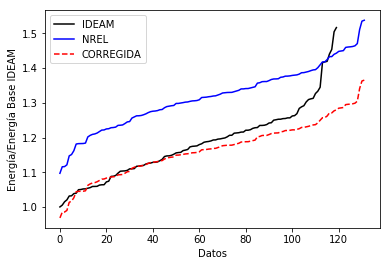

In [39]:
grafica3(datos_IDEAM,datos_NREL, datos_CORREGIDOS,ciudad,det)

## 4. Cálculos de error

In [14]:
#La cantidad de datos es diferente entonces el error lo calculo con la misma cantidad de datos organizados.
len(datos_CORREGIDOS)


132

In [15]:
len(datos_NREL)

132

In [16]:
len(datos_IDEAM)

120

In [17]:
#Donde la serie1 es la observada en tierra y la serie 2 es la modelada del satélite
#Deben entrar dos listas *ordenadas* de los promedios diarios medidos como los que se graficaron anteriormente
def MBE (serie1,serie2): 
    #Hago que las listas queden del mismo tamaño 
    serie2 = serie2[:len(serie1)]
    
    suma1 = sum(serie1)
    suma2 = sum(serie2)
    error = suma2-suma1
    result = error / suma1
    
        
    
    return print('El MBE es:',"{:.2%}".format(result))
   

In [18]:
MBE(datos_IDEAM,datos_NREL)
MBE(datos_IDEAM,datos_CORREGIDOS)


El MBE es: 10.07%
El MBE es: -2.55%


In [19]:
len(datos_CORREGIDOS)

132

In [20]:
len(datos_IDEAM)

120

In [21]:
len(datos_CORREGIDOS)

132

In [22]:
#Donde la serie1 es la observada en tierra y la serie 2 es la modelada del satélite
#Deben entrar dos listas *ordenadas* de los promedios diarios medidos como los que se graficaron anteriormente
def RMSE (serie1,serie2): 
    serie2 = serie2[:len(serie1)]
    error = 0
    sumatoria = 0
    for i in range(0,len(serie1)):
        ghi_obs = serie1[i]
        ghi_mod = serie2[i]
        resta = (ghi_obs - ghi_mod)**2
        error = error + resta
        sumatoria = sumatoria + ghi_obs
        
    error = sqrt(error/len(serie1))
    result = error / (serie1[-1]-serie1[0])  
    
    return print('El RMSE es:',"{:.2%}".format(result))
   


In [23]:
RMSE(datos_IDEAM,datos_NREL)
RMSE(datos_IDEAM,datos_CORREGIDOS)


El RMSE es: 24.34%
El RMSE es: 10.52%


In [24]:
len(datos_CORREGIDOS)

132

In [25]:
len(datos_IDEAM)

120

In [26]:
len(datos_NREL)

132

In [27]:
#Importa la libreria para comparar las series
from scipy import stats

In [28]:
# Usar .stats.ks_2samp como KSI con datos equivalentes
def KSI (serie1, serie2):
    serie2 = serie2[:len(serie1)]
    error = stats.ks_2samp(serie1, serie2)
    return print('El pvalue es:',"{:.2%}".format(error[-1]))

    

In [29]:
KSI(datos_IDEAM,datos_CORREGIDOS)
KSI(serie_pd['IDEAM'],corregida['NREL'])

El pvalue es: 2.09%
El pvalue es: 0.00%


In [30]:
len(datos_CORREGIDOS)

132

In [31]:
len(datos_IDEAM)

120

In [32]:
len(datos_NREL)

132

## Análisis

Para el análisis de los datos se pensó usar primero los datos de Santa Marta, pero los datos medidos en tierra (IDEAM) no cumplían la condición de tener diez años en muestras. De los datos disponibles, los **únicos** que cumplen con esta característica son: Medellín, Sucre, Uribia y Valledupar. 

###### Tabla 1. Resumen de errores comparados para diferentes tiempos corregidos y sin corregir.
Lugar    | Año  | Meses | MBE | RMSE | PVALUE| Corregido 
---------|------|-------|-----|------|-------|----------
Medellin | 2010 | 3-12  | 11% | 5%   | 0.5   | NO  